## Watson Assistant Conversational Flow Coverage Notebook.

The purpose of this notebook is to allow to analyse how your conversational flows are performing in the real world.

---

Start by loading up the JSON data which is a conversational log dump from the demo assistant.

In [1]:
import networkx as nx
import pandas as pd
import json
from pylab import rcParams
import matplotlib.pyplot as plt

with open('logs.json') as f:
    data = json.load(f)

data = data[0]

with open('skill-Customer-Care-Sample-Skill.json') as f:
    skill = json.load(f)


Format the data to allow us to parse it correctly and only use data we need.

In [2]:
recs = []
for index, d in enumerate(data):
    output = d['response']['output']
    timestamp = d['response_timestamp']
    cid = d['response']['context']['conversation_id']

    if 'nodes_visited' in output:
        nodes = output['nodes_visited']
    else:
        nodes = []

    text = ' '.join(output['text'])

    recs.append( {
        'timestamp': timestamp,
        'conversation_id': cid,
        'nodes': nodes,
        'text': text
    })

df = pd.DataFrame(recs)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.sort_values(by=['conversation_id', 'timestamp'], inplace=True)

df.head(3)

timestamp                       conversation_id  \
41 2021-10-02 08:00:47.396000+00:00  31a84ee1-079a-4d00-a780-5cfbf34cc25d   
42 2021-10-02 08:00:52.050000+00:00  31a84ee1-079a-4d00-a780-5cfbf34cc25d   
43 2021-10-02 08:00:56.225000+00:00  31a84ee1-079a-4d00-a780-5cfbf34cc25d   

                                             nodes  \
41                                       [Opening]   
42  [node_13_1502484041694, node_16_1488295517679]   
43                          [node_4_1570050459690]   

                                                 text  
41  Hello, I’m a demo customer care virtual assist...  
42                                Hello. Good morning  
43  I can tell you about our store locations and o...

Nodes can chain across rows, so create the node chains as single lists.
We don't care about the conversation IDs except as a way to separate out chains.

In [5]:
last_id = ''
last_node = None
branches = []
current = []
for index, row in df.iterrows():
    nodes = row['nodes']
    conversation_id = row['conversation_id']

    if last_id == '':
        last_id = conversation_id
    elif conversation_id != last_id:
        # cleanup
        branches.append(current)
        current = []
        last_node = None
        last_id = conversation_id
        pass

    if len(nodes) > 0:
        first = nodes[0]
        last = nodes[len(nodes) - 1]

        if last_node is None:
            last_node = last
            current = nodes
        else:
            if first == last_node:
                current = current[:-1]  + nodes
            else:
                branches.append(current)
                current = nodes
                last_node = last

branches.append(current)

Make the nodes somewhat readable.

In [66]:
dialog = {}
for d in skill['dialog_nodes']:
    t = d['type']
    if t == 'slot':
        dialog[d['dialog_node']] = f'slot: {d["variable"]}'
    elif t == 'standard' and d['dialog_node'].startswith('node_'):
        dialog[d['dialog_node']] = d["conditions"]
    elif t == 'response_condition':
        dialog[d['dialog_node']] = 'response to: {}'.format(d['parent'])
    elif t == 'frame':
        dialog[d['dialog_node']] = 'frame: {}'.format(d['conditions'])
    else:
        dialog[d['dialog_node']] = d['dialog_node']

for i1, branch in enumerate(branches):
    for i2, value in enumerate(branch):
        if value in dialog:
            branches[i1][i2] = dialog[value]

Now create the graph.

In [67]:
nodes = list(set(list(zip(*branches))[0]))

G = nx.DiGraph()
G.add_nodes_from(nodes)

edges = []
for branch in branches:
    for n in range(0, len(branch) -1):
        edges.append((branch[n], branch[n+1]))

for edge in edges:
    if G.has_edge(edge[0], edge[1]):
        G[edge[0]][edge[1]]['count'] = G[edge[0]][edge[1]]['count'] + 1
    else:
        G.add_edge(edge[0], edge[1])
        G[edge[0]][edge[1]]['count'] = 1

In [68]:
def build_output(G):
    root_nodes = []
    colors = []
    for node, degree in G.in_degree():
        if degree == 0:
            root_nodes.append(node)
            colors.append('red')
        elif node.startswith('handler_'):
            colors.append('lightgreen')
        elif node.startswith('frame: '):
            colors.append('orange')
        elif node.startswith('response to: '):
            colors.append('pink')
        else:
            colors.append('cyan')

    weights = [G[u][v]['count'] for u,v in G.edges]

    return root_nodes, colors, weights

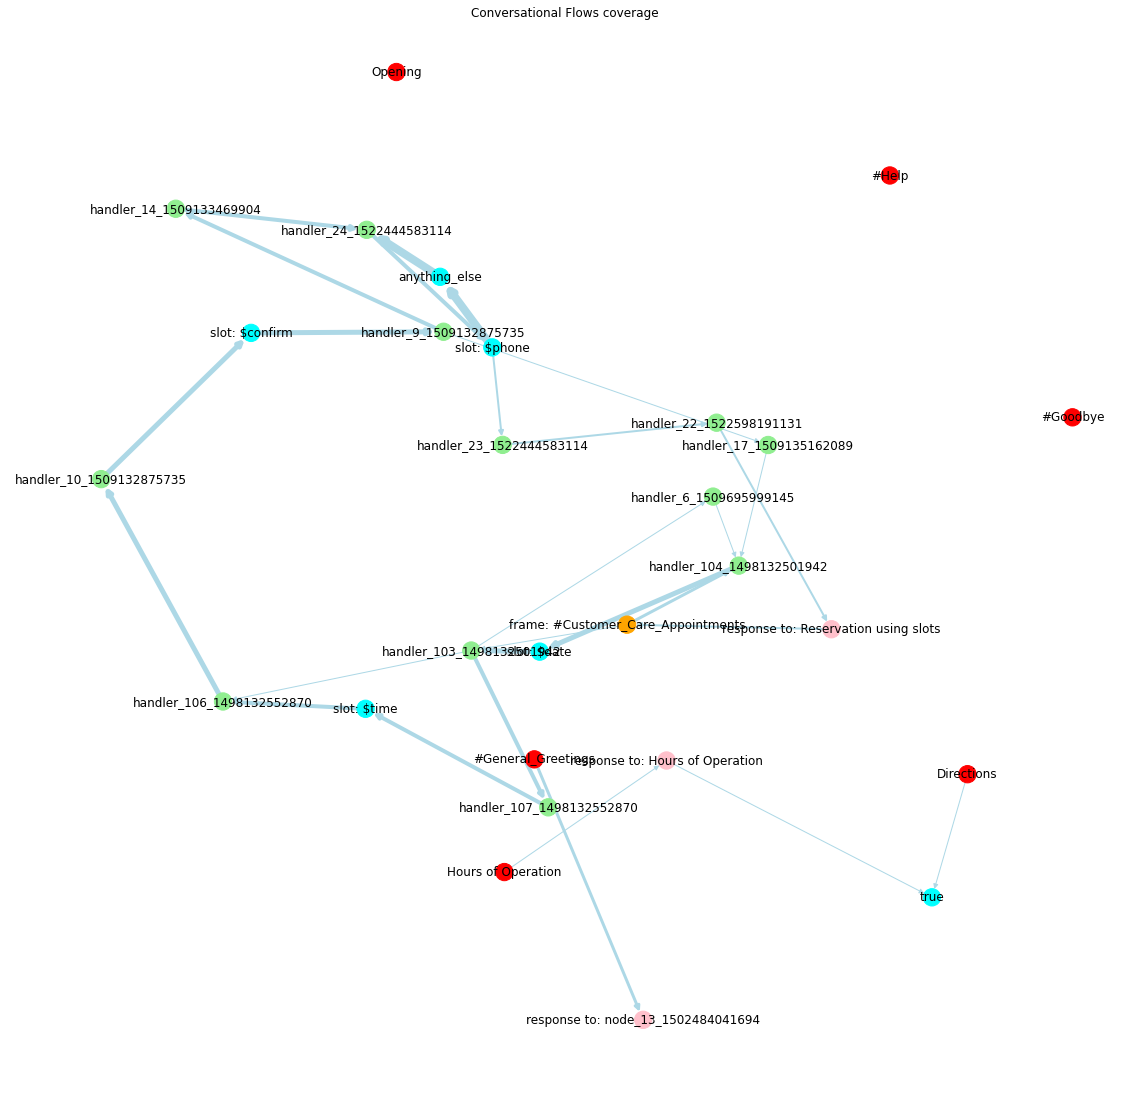

In [70]:
root_nodes, colors, weights = build_output(G)

rcParams['figure.figsize'] = 20, 20
pos = nx.spring_layout(G, k=0.5, iterations=60)
ax = plt.gca()
ax.set_title('Conversational Flows coverage')
nx.draw(G, pos, with_labels=True, width=weights, node_color=colors, edge_color=['lightblue'] * len(G.edges))

Too many dialog nodes and that can turn into a hot mess. Let's just look at the main slot.

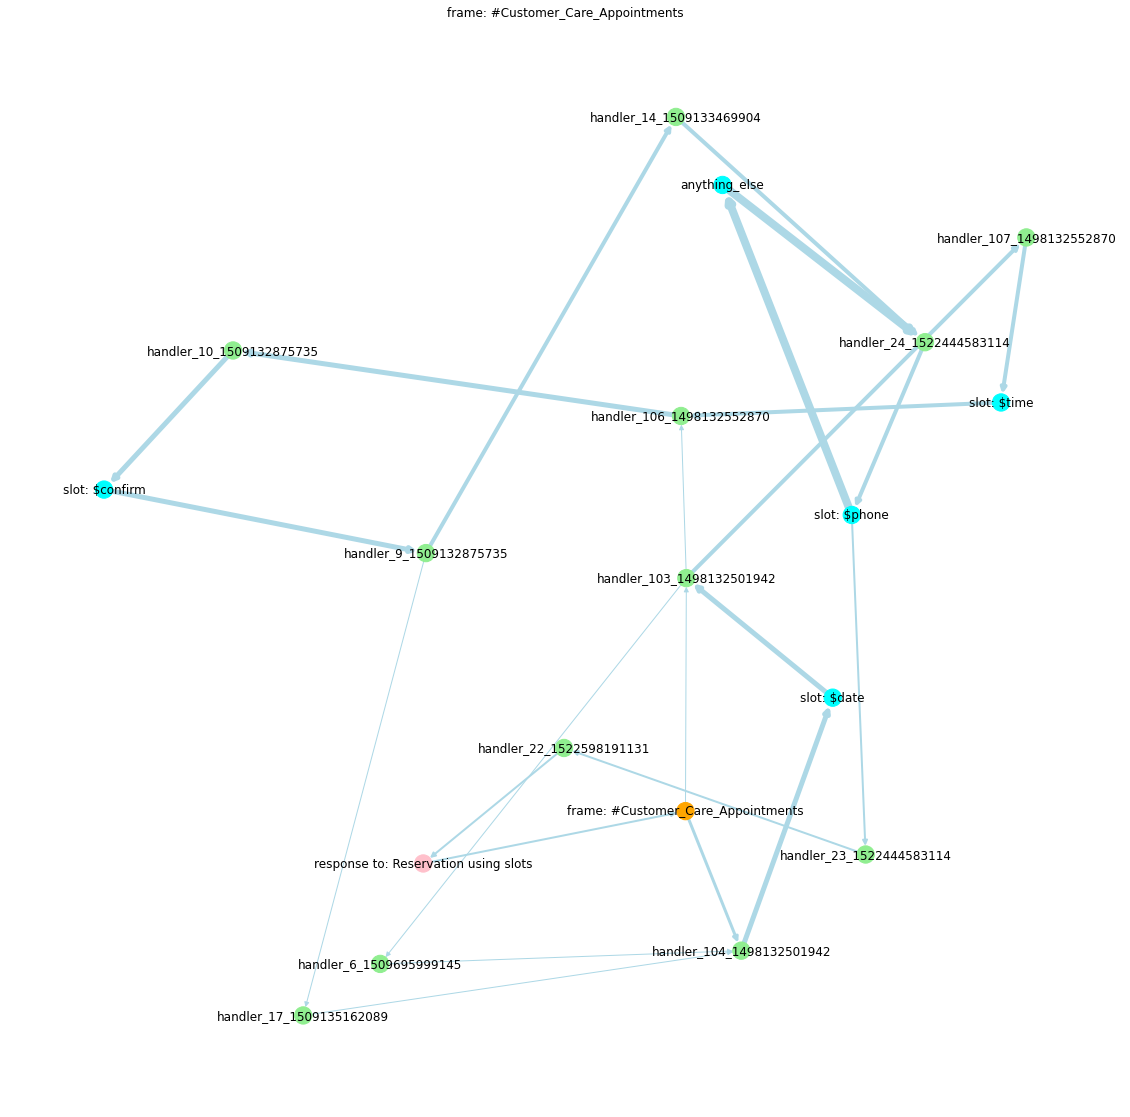

In [74]:
root = 'frame: #Customer_Care_Appointments'

F = G.copy()

for n in G.nodes:
    if not nx.has_path(G, root, n):
        F.remove_node(n)

root_nodes, colors, weights = build_output(F)

rcParams['figure.figsize'] = 20, 20
pos = nx.spring_layout(F, k=0.5, iterations=60)
ax = plt.gca()
ax.set_title(root)
nx.draw(F, pos, with_labels=True, width=weights, node_color=colors, edge_color=['lightblue'] * len(G.edges))

Still a little hard to follow, so let's try a different visualisation.

In [75]:
import plotly.graph_objects as go

label = []
ldict = {}
for i, n in enumerate(F.nodes):
    ldict[n] = i
    label.append(n)

source = []
target = []
value = []

node_list = list(F.nodes)
node_list.reverse()

for n in node_list:
    s = ldict[n]
    for e in F.edges(n):
        t = ldict[e[1]]
        v = F[e[0]][e[1]]['count']

        source.append(s)
        target.append(t)
        value.append(v)

Generate Sankey

In [100]:
# Color outgoing links mistyrose if the incoming to node is lower than the outgoing.
# mistyrose aliceblue
total_nodes = len(F.nodes)
inout = {}
for x in range(total_nodes):
    inout[x] = {'in': 0, 'out': 0}

for x in range(total_nodes):
    v = value[x]
    inout[source[x]]['out'] = inout[source[x]]['out'] + v
    inout[target[x]]['in'] = inout[target[x]]['in'] + v

In [117]:
link_colors = []
for x in source:
    if inout[x]['in'] < inout[x]['out']:
        link_colors.append('mistyrose')
    else:
        link_colors.append('gainsboro')

fig = go.Figure(data=[go.Sankey(
    node = dict(pad=15, thickness=20, line=dict(color=colors, width=0.5), label=label, color=colors),
    link = dict(source=source, target=target, value=value, color=link_colors)
)])

fig.update_layout(autosize=False, width=1600, height=800, title_text=root, font_size=10,
    margin=dict( l=50, r=50, b=100, t=100, pad=4)
)

fig.show()

19